In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [3]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [289]:
p = {}
p1 = load_obj('pred_month_normalstatic_adagrad_0_10')
p2 = load_obj('pred_month_normalstatic_adagrad_0_50') 
p3 = load_obj('pred_month_normalstatic_adagrad_0_90') 

In [290]:
def save_obj(obj, name ):
    with open(os.path.expanduser('~/git/'+ name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [291]:
p = {}
for appliance in APPLIANCES_ORDER:
    print (appliance)
    p[appliance] = {}
    p[appliance][10] = p1[appliance][10]
    p[appliance][50] = p2[appliance][50]
    p[appliance][90] = p3[appliance][90]

aggregate
hvac
fridge
mw
dw
wm
oven


In [292]:
save_obj(p, "pred_month_normal_static_adagrad_0")

In [229]:
pred = load_obj("pred_month_normal_static_adagrad_0")

In [230]:
o = {}
for appliance in APPLIANCES_ORDER[1:]:
    o[appliance] = {}
    for f in range(10, 110, 40):
        s = pd.concat(pred[appliance][f]).ix[sd_df.index]
        if appliance=="hvac":
            o[appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
        else:   
            o[appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [231]:
o

{'dw': {10: 1.9626707149562719, 50: 1.9863556728276968, 90: 1.979902704051927},
 'fridge': {10: 7.8530361070769539,
  50: 8.2127444247483918,
  90: 8.3611574584505099},
 'hvac': {10: 14.561364033400395,
  50: 15.869603143996793,
  90: 15.505464617848526},
 'mw': {10: 2.1341399630178022,
  50: 2.1543984239307536,
  90: 2.1634359522001305},
 'oven': {10: 2.0100930731020763,
  50: 2.0546804746796639,
  90: 2.0656627304267867},
 'wm': {10: 0.71659545253453649,
  50: 0.70031446986877488,
  90: 0.69857004696974001}}

## Leave one cell out for transfer learning and normal learning

### algo: adagrad with static factors, no sparse constraints

In [66]:
import cPickle as pickle
def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [293]:
pred_transfer_loo = {}
for static_fac in ['static', 'None']:
    pred_transfer_loo[static_fac] = {}
    for algo in ['adagrad', 'gd']:
        pred_transfer_loo[static_fac][algo] = {}
        for random_seed in range(1):
            pred_transfer_loo[static_fac][algo][random_seed] = load_obj("pred_month_" 
                                                           + static_fac + "_" + algo + "_" + str(random_seed))

In [295]:
pred_normal_loo = {}
for static_fac in ['static']:
    pred_normal_loo[static_fac] = {}
    for algo in ['adagrad']:
        pred_normal_loo[static_fac][algo] = {}
        for random_seed in range(1):
            pred_normal_loo[static_fac][algo][random_seed] = load_obj("pred_month_normal_" 
                                                           + static_fac + "_" + algo + "_" + str(random_seed))

In [296]:
out_transfer_loo = {}
for static_fac in ['static', 'None']:
    out_transfer_loo[static_fac] = {}
    for algo in ['adagrad', 'gd']:
        out_transfer_loo[static_fac][algo] = {}
        for random_seed in range(1):
            out_transfer_loo[static_fac][algo][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out_transfer_loo[static_fac][algo][random_seed][appliance] = {}
                for f in range(10, 110, 40):
                    s = pd.concat(pred_transfer_loo[static_fac][algo][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out_transfer_loo[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out_transfer_loo[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [297]:
out_normal_loo = {}
for static_fac in ['static']:
    out_normal_loo[static_fac] = {}
    for algo in ['adagrad']:
        out_normal_loo[static_fac][algo] = {}
        for random_seed in range(1):
            out_normal_loo[static_fac][algo][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out_normal_loo[static_fac][algo][random_seed][appliance] = {}
                for f in range(10, 110, 40):
                    s = pd.concat(pred_normal_loo[static_fac][algo][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out_normal_loo[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out_normal_loo[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


## Transfer learning: previous setting. Leave all appliances consumpition out

In [102]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)
static_sd = df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [106]:
# learn A_au from Austin

pred_transfer = {}
b = 3

n_splits = 10
kf = KFold(n_splits = n_splits)

for static_fac in ['static', 'None']:
    
    pred_transfer[static_fac] = {}
    if static_fac == 'None':
        H_known_Au = None
        H_known_Sd = None
    else:
        H_known_Au = static_au
        H_known_Sd = static_sd
        
    for algo in ['adagrad', 'gd']:
        pred_transfer[static_fac][algo] = {}
        if algo == 'adagrad':
            cost = 'l21'
            if static_fac == 'static':
                a = 5
                H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known = H_known_Au, T_known=np.ones(12).reshape(-1, 1))
            else:
                a = 2
                H_au, A_au, T_au, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
        else:
            cost = 'abs'
            if static_fac == 'static':
                a = 5
                H_au, A_au, T_au = learn_HAT(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known = H_known_Au, T_known=np.ones(12).reshape(-1, 1))
            else:
                a = 2
                H_au, A_au, T_au = learn_HAT(case, au_tensor, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
        
        print (static_fac, algo)
        for random_seed in range(1):
            pred_transfer[static_fac][algo][random_seed] = {}
            for appliance in APPLIANCES_ORDER:
                pred_transfer[static_fac][algo][random_seed][appliance] = {f:[] for f in range(10, 110, 40)}
            
        for random_seed in range(1):
            print "random seed: ", random_seed
            for train_percentage in range(10, 110, 40):
                print "training percentage: ", train_percentage
                rd = 0
                for train_max, test in kf.split(sd_df):
                    print "round: ", rd

                    num_train = int((train_percentage*len(train_max)/100)+0.5)
                    num_test = len(test)

                    # get the random training data from train_max based on then random seed
                    if train_percentage==100:
                        train = train_max
                    else:
                        train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                    # get the index of training and testing data
                    train_ix = sd_df.index[train]
                    test_ix = sd_df.index[test]
                    print "test_ix: ", test_ix

                    # create the tensor
                    train_test_ix = np.concatenate([test_ix, train_ix])
                    df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                    tensor = get_tensor(df_t, dfc_t)

                    tensor_copy = tensor.copy()
                    tensor_copy[:num_test, 1:, :] = np.NaN
                    
                    if algo == 'adagrad':
                        cost = 'l21'
                        if static_fac == 'static':
                            a = 5
                            H_sd, A_sd, T_sd, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known = H_known_Sd[np.concatenate([test, train])], A_known = A_au, T_known=np.ones(12).reshape(-1, 1))
                        else:
                            a = 2
                            H_sd, A_sd, T_sd, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known = A_au, T_known=np.ones(12).reshape(-1, 1))
                    else:
                        cost = 'abs'
                        if static_fac == 'static':
                            a = 5
                            H_sd, A_sd, T_sd = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known = H_known_Sd[np.concatenate([test, train])], A_known = A_au, T_known=np.ones(12).reshape(-1, 1))
                        else:
                            a = 2
                            H_sd, A_sd, T_sd = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known = A_au, T_known=np.ones(12).reshape(-1, 1))

                    HAT = multiply_case(H_sd, A_sd, T_sd, case)
                    for appliance in APPLIANCES_ORDER:
                        pred_transfer[static_fac][algo][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
                    rd += 1

('static', 'adagrad')
random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  50
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype

In [107]:
out_transfer = {}
for static_fac in ['static', 'None']:
    out_transfer[static_fac] = {}
    for algo in ['adagrad', 'gd']:
        out_transfer[static_fac][algo] = {}
        for random_seed in range(1):
            out_transfer[static_fac][algo][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out_transfer[static_fac][algo][random_seed][appliance] = {}
                for f in range(10, 110, 40):
                    s = pd.concat(pred_transfer[static_fac][algo][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out_transfer[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out_transfer[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [111]:
out_transfer['None']['gd'][0]

{'dw': {10: 1.8637732399159872,
  50: 1.8377617957637469,
  90: 1.8286292117254166},
 'fridge': {10: 10.245941189095824,
  50: 10.407028287872855,
  90: 9.9915816714298629},
 'hvac': {10: 21.055925027696674,
  50: 17.726031918853106,
  90: 16.766692087381799},
 'mw': {10: 1.9305216541502845,
  50: 1.9979852010404198,
  90: 2.0446553513952237},
 'oven': {10: 2.1027408299229617,
  50: 2.0745164645182403,
  90: 2.0408639586724302},
 'wm': {10: 0.84695899755891035,
  50: 0.85241132002210984,
  90: 0.82586444701793982}}

### Normal learning in SanDiego: different algorithm for gradient descent with or without static factors

In [114]:
# learn A_au from Austin

pred_normal = {}
b = 3

n_splits = 10
kf = KFold(n_splits = n_splits)

for static_fac in ['static', 'None']:
    
    pred_normal[static_fac] = {}
    if static_fac == 'None':
        H_known_Au = None
        H_known_Sd = None
    else:
        H_known_Au = static_au
        H_known_Sd = static_sd
    for algo in ['adagrad', 'gd']:   
        pred_normal[static_fac][algo] = {}
        
        print (static_fac, algo)
        for random_seed in range(1):
            pred_normal[static_fac][algo][random_seed] = {}
            for appliance in APPLIANCES_ORDER:
                pred_normal[static_fac][algo][random_seed][appliance] = {f:[] for f in range(10, 110, 40)}
            
        for random_seed in range(1):
            print "random seed: ", random_seed
            for train_percentage in range(10, 110, 40):
                print "training percentage: ", train_percentage
                rd = 0
                for train_max, test in kf.split(sd_df):
                    print "round: ", rd

                    num_train = int((train_percentage*len(train_max)/100)+0.5)
                    num_test = len(test)

                    # get the random training data from train_max based on then random seed
                    if train_percentage==100:
                        train = train_max
                    else:
                        train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                    # get the index of training and testing data
                    train_ix = sd_df.index[train]
                    test_ix = sd_df.index[test]
                    print "test_ix: ", test_ix

                    # create the tensor
                    train_test_ix = np.concatenate([test_ix, train_ix])
                    df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                    tensor = get_tensor(df_t, dfc_t)

                    tensor_copy = tensor.copy()
                    tensor_copy[:num_test, 1:, :] = np.NaN
                    
                    if algo == 'adagrad':
                        cost = 'l21'
                        if static_fac == 'static':
                            a = 5
                            H_sd, A_sd, T_sd, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known = H_known_Sd[np.concatenate([test, train])], A_known = A_au, T_known=np.ones(12).reshape(-1, 1))
                        else:
                            a = 2
                            H_sd, A_sd, T_sd, Hs, As, Ts, HATs, costs = learn_HAT_adagrad(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
                    else:
                        cost = 'abs'
                        if static_fac == 'static':
                            a = 5
                            H_sd, A_sd, T_sd = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, H_known = H_known_Sd[np.concatenate([test, train])], A_known = A_au, T_known=np.ones(12).reshape(-1, 1))
                        else:
                            a = 2
                            H_sd, A_sd, T_sd = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))

                    HAT = multiply_case(H_sd, A_sd, T_sd, case)
                    for appliance in APPLIANCES_ORDER:
                        pred_normal[static_fac][algo][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
                    rd += 1

('static', 'adagrad')
random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  50
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype

In [116]:
out_normal = {}
for static_fac in ['static', 'None']:
    out_normal[static_fac] = {}
    for algo in ['adagrad', 'gd']:
        out_normal[static_fac][algo] = {}
        for random_seed in range(1):
            out_normal[static_fac][algo][random_seed] = {}
            for appliance in APPLIANCES_ORDER[1:]:
                out_normal[static_fac][algo][random_seed][appliance] = {}
                for f in range(10, 110, 40):
                    s = pd.concat(pred_normal[static_fac][algo][random_seed][appliance][f]).ix[sd_df.index]
                    if appliance=="hvac":
                        out_normal[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out_normal[static_fac][algo][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


### Results Analysis

In [131]:
mean_out_transfer_const = pd.Panel(out_normal['static']['gd']).mean(axis=0)
mean_out_transfer_const

,dw,fridge,hvac,mw,oven,wm
10,1.735139,8.663529,20.713798,1.742947,2.742882,2.873620
50,1.922558,7.186668,21.591270,1.763555,2.288945,0.920293
90,1.865270,8.564194,17.648483,1.990311,2.100723,0.610927


In [309]:
df = {}
df['normal'] = {}
df['normal']['loo'] = {}
df['normal']['standard'] = {}
for static_fac in ['static']:
    df['normal']['standard'][static_fac] = {}
    for algo in ['adagrad']:
        df['normal']['standard'][static_fac][algo] = pd.Panel(out_normal[static_fac][algo]).mean(axis=0)

In [310]:
df['transfer'] = {}
df['transfer']['loo'] = {}
df['transfer']['standard'] = {}
for static_fac in ['static']:
    df['transfer']['standard'][static_fac] = {}
    for algo in ['adagrad']:
        df['transfer']['standard'][static_fac][algo] = pd.Panel(out_transfer[static_fac][algo]).mean(axis=0)

In [311]:
for static_fac in ['static']:
    df['transfer']['loo'][static_fac] = {}
    for algo in ['adagrad']:
        df['transfer']['loo'][static_fac][algo] = pd.Panel(out_transfer_loo[static_fac][algo]).mean(axis=0)

In [312]:
for static_fac in ['static']:
    df['normal']['loo'][static_fac] = {}
    for algo in ['adagrad']:
        df['normal']['loo'][static_fac][algo] = pd.Panel(out_normal_loo[static_fac][algo]).mean(axis=0)

In [315]:
# rename

for method in ['normal', 'transfer']:
    for way in ['loo', 'standard']:
        for static_fac in ['static']:
            for algo in ['adagrad']:
                df[method][way][static_fac][algo] = df[method][way][static_fac][algo].rename(columns=
                                            {'dw': "dw_" + method + "_" + way + "_" + static_fac + "_" + algo,
                                              'wm': "wm_" + method + "_" + way + "_"+ static_fac + "_" + algo,
                                              'mw': "mw_" + method + "_" + way + "_"+ static_fac + "_" + algo,
                                              'oven': "oven_" + method + "_" + way + "_"+ static_fac + "_" + algo,
                                              'fridge': "fridge_"+ method + "_" + way + "_"+ static_fac + "_" + algo,
                                              'hvac': "hvac_"+ method + "_" + way + "_" + static_fac + "_" + algo})

In [239]:
appliance + "_" + method + "_" + static_fac + "_" + algo

'oven_loo_None_gd'

In [240]:
df[method][static_fac][algo]['fridge' + "_" + method + "_" + static_fac + "_" + algo]

10    10.409706
50     9.839873
90     9.885738
Name: fridge_loo_None_gd, dtype: float64

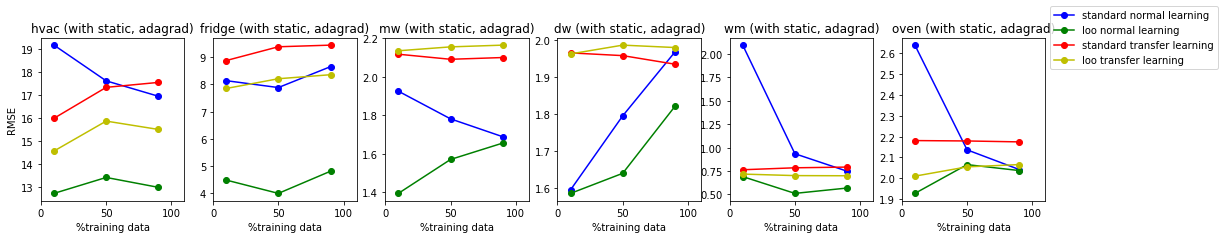

In [329]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 3))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
    dfs = {}
    num = 0
    
    for method in ['normal', 'transfer']:
        for way in ['standard', 'loo']:
            for static_fac in ['static']:
                for algo in ['adagrad']:
                    dfs[num] = df[method][way][static_fac][algo][appliance + "_" + method + "_" + way + "_" + static_fac + "_" + algo]
                    num+=1

    df_plt_1 = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3]], axis = 1)
#     df_plt_2 = pd.concat([dfs[1], dfs[5], dfs[9]], axis = 1)
#     df_plt_3 = pd.concat([dfs[2], dfs[6], dfs[10]], axis = 1)
#     df_plt_4 = pd.concat([dfs[3], dfs[7], dfs[11]], axis = 1)
    
    pd.DataFrame(df_plt_1).plot(ax=ax[count], marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].set_xlabel("%training data")
    
    ax[count].legend().set_visible(False)
    ax[count].set_title(appliance + " (with static, adagrad)")
    count += 1
    
    
#     pd.DataFrame(df_plt_2).plot(ax=ax[count],figsize=(30, 30), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
#     ax[count].legend().set_visible(False)
#     ax[count].set_xlabel("%training data")
#     ax[count].set_title(appliance + " (with static, gd)")
#     count += 1
    
    
#     pd.DataFrame(df_plt_3).plot(ax=ax[count],figsize=(30, 30), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
#     ax[count].set_title(appliance + " (without static, adagrad)")
#     ax[count].set_xlabel("%training data")
#     ax[count].legend().set_visible(False)
#     count += 1
    
    
#     pd.DataFrame(df_plt_4).plot(ax=ax[count],figsize=(30, 30), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
#     ax[count].set_title(appliance + " (without static, gd)")
#     ax[count].set_xlabel("%training data")
#     ax[count].legend().set_visible(False)
#     ax[count].legend(['normal learning', 'transfer learning', 'Leave one out transfer learning'], loc='center left' , bbox_to_anchor=(1, 1), title='Lambda')
#     count += 1
ax[0].set_ylabel("RMSE")    
ax[count-1].legend(['standard normal learning', 'loo normal learning', 'standard transfer learning', 'loo transfer learning'], loc='center left' , bbox_to_anchor=(1, 1))

plt.savefig("./analysis/0720/leave_one_out_all.pdf", bbox_inches="tight", dpi=300, format="pdf")

In [34]:

for i in range(m):
    for j in range(1,n):
        for k in range(o):
            print i, j, k
            tensor_copy = sd_tensor.copy()
            tensor_copy[i, j, k] = np.NaN
            
            H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known = A_a, T_known=np.ones(12).reshape(-1, 1))
            prediction = multiply_case(H, A, T, case)
            
            pred_cell[i][j][k] = prediction[i][j][k]

0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 4 10
0 4 11
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 5 6
0 5 7
0 5 8
0 5 9
0 5 10
0 5 11
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 6 7
0 6 8
0 6 9
0 6 10
0 6 11
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 2 10
1 2 11
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 3 10
1 3 11
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 4 10
1 4 11
1 5 0
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 5 6
1 5 7
1 5 8
1 5 9
1 5 10
1 5 11
1 6 0
1 6 1
1 6 2
1 6 3
1 6 4
1 6 5
1 6 6
1 6 7
1 6 8
1 6 9
1 6 10
1 6 11
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 

In [70]:
from scipy.optimize import nnls

n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'


pred_cv = {}
for random_seed in range(10):
    
    pred_cv[random_seed] = {}
    for appliance in APPLIANCES_ORDER:
        pred_cv[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(5):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
                print "round: ", rd

                num_train = int((train_percentage*len(train_max)/100)+0.5)
                num_test = len(test)

                # get the random training data from train_max based on then random seed
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                # get the index of training and testing data
                train_ix = sd_df.index[train]
                test_ix = sd_df.index[test]
                print "test_ix: ", test_ix

                # create the tensor
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, dfc_t)


                #############################################################################################
                # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
                ############################################################################################
                pred = np.empty([num_test, 7, 12])
                
                for i in range(1, 7):
                    for j in range(12):
                    
                        print i, j
                        tensor_copy = tensor.copy()
                        tensor_copy[:num_test, i, j] = np.NaN
                        H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a,T_known = np.ones(12).reshape(-1, 1))
                        HAT = multiply_case(H, A, T, case)
                        pred[:, i, j] = HAT[:num_test, i, j]
                # get the prediction
                
                for appliance in APPLIANCES_ORDER:
                    pred_cv[random_seed][appliance][train_percentage].append(pd.DataFrame(pred[:, appliance_index[appliance], :], index=test_ix))

                rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 

KeyboardInterrupt: 

In [83]:
pred_cv[0]['fridge']

{10: [             0          1          2          3          4          5   \
  54    15.067506  14.750169  15.152734  16.280202  20.258232  20.871764   
  203   20.193407  19.754779  20.324603  21.894663  27.649882  28.429111   
  527   43.488306  42.530516  43.775555  47.213606  60.046971  61.733262   
  1450  39.890370  39.044341  40.126148  43.140292  53.819649  55.435745   
  
               6          7          8          9          10         11  
  54    20.542532  24.713764  24.975883  20.594470  16.988741  21.117388  
  203   28.292457  34.113796  34.459890  28.016192  22.859454  28.580013  
  527   61.787706  74.596432  75.353648  60.804724  49.338222  61.865798  
  1450  54.638602  65.787352  66.417296  54.647597  45.000681  55.992838  ,
               0          1          2          3          4          5   \
  1524  43.674540  39.337543  40.519911  45.899222  58.411080  57.007935   
  1731  34.251842  30.978370  31.860719  35.910018  44.984866  44.152264   
  2031  1

In [54]:
pred_cv[0]['dw'][10]

[             0          1          2          3          4          5   \
 54     4.441050   4.374520   4.457078   4.687009   4.945526   5.192324   
 203    5.503513   5.430953   5.521882   5.773382   6.090897   6.353401   
 527   11.354342  11.216256  11.390482  11.870073  12.521796  13.012461   
 1450  11.623782  11.452640  11.665282  12.256978  12.932745  13.565594   
 
              6          7          8          9          10         11  
 54     4.288658   5.120256   5.142503   5.153532   4.816868   5.673344  
 203    5.416679   6.326773   6.352496   6.309071   5.915830   6.851801  
 527   11.295028  13.031156  13.082057  12.925400  12.142253  13.925949  
 1450  11.255776  13.395926  13.453595  13.465194  12.591277  14.795044  ,
              0          1          2          3          4          5   \
 1524  10.809674  10.263070  10.387690  11.045619  11.730628  12.102732   
 1731   9.438079   8.860635   8.989631   9.682273  10.311600  10.761934   
 2031   4.138151   3.872244

In [38]:
pred_cell[:, 1, :]

array([[   0.        ,    0.        ,    0.        ,   11.18723443,
          85.89969937,   54.95676031,  138.22499142,  165.33004297,
         174.06390724,   64.82408541,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,   16.36920788,
         122.07919527,   79.19176856,  196.30009438,  243.430618  ,
         282.42734073,   99.45670315,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,   39.09422878,
         291.55912891,  194.69024705,  496.86355717,  573.53475427,
         598.77516629,  228.69533   ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,   34.03037097,
         227.21695396,  149.7512468 ,  391.03006304,  424.19545117,
         456.80554756,  163.1795575 ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,   40.52508894,
         302.23027798,  201.81596682,  515.04890814,  622.49467606,
         683.39460301,  253.12000959,    0. 

In [41]:
out = {}
for appliance in APPLIANCES_ORDER[1:]:
    out[appliance] = {}
    
    s = pd.DataFrame(pred_cell[:, appliance_index[appliance], :], index = sd_df.index)
    
    if appliance=="hvac":
        out[appliance] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
    else:   
        out[appliance] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [42]:
out

{'dw': 1.8419311486511902,
 'fridge': 9.8563926947604124,
 'hvac': 13.355191358765531,
 'mw': 2.0429952976254757,
 'oven': 2.0290824167898225,
 'wm': 0.80628242095805347}

In [85]:
out_cv = {}
for random_seed in range(1):
    out_cv[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_cv[random_seed][appliance] = {}
        for f in range(10,20,10):
            s = pd.concat(pred_cv[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_cv[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_cv[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [86]:
out_cv

{0: {'dw': {10: 1.8511217053352107},
  'fridge': {10: 10.409705903351151},
  'hvac': {10: 15.199581098682868},
  'mw': {10: 1.9182482790934556},
  'oven': {10: 2.0871632432596376},
  'wm': {10: 0.81793246666963448}}}